# Supplementary Figure 8: Heatmaps of GSEA enrichment for Lenalidomide and Dexamethasone MAST DEGs against Reactome Pathways

In supplementary figure 8, we present NES scores and significant results from Gene Set Enrichment Analysis of Reactome Pathways. Pathways are grouped based on the ontological relationships in the Reactome database - parent and child relationships are represented by relative positioning of labels and indentation.

These relationships were previously structured in the analysis notebook for the GSEA analysis or Reactome pathways and were stored in HISE along with the analysis results.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/supp_figure_08"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Download results from HISE

We'll obtain the Reactome results and pathway sets from the analysis results stored in HISE.

In [3]:
gsea_uuid <- list("574d1167-4232-4e45-ad25-c240cc2b2b4d")

In [4]:
gsea_fres <- cacheFiles(gsea_uuid)
gsea_file <- list.files(
    paste0("cache/",gsea_uuid),
    full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [5]:
react_uuid <- list("b2815555-cad9-4979-8f4f-6d772073f345")

In [6]:
react_fres <- cacheFiles(react_uuid)
react_file <- list.files(
    paste0("cache/",react_uuid),
    full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



### Read and structure Reactome sets

For plotting, we need to set the order of the reactome gene sets based on their hierarchical relationships.

In [7]:
reactome_data <- readRDS(react_file)

In [8]:
root_order <- reactome_data$root_tb %>%
  select(root_id, root_name) %>%
  arrange(root_name) %>%
  mutate(root_order = 1:n())
l1_order <- reactome_data$l1_tb %>%
  left_join(root_order) %>%
  select(root_order, l1_id, l1_name) %>%
  arrange(root_order, l1_name) %>%
  mutate(l1_order = 1:n())
l2_order <- reactome_data$l2_tb %>%
  left_join(l1_order) %>%
  arrange(l1_order, l2_id, l2_name) %>%
  mutate(l2_order = 1:n())
l3_order <- reactome_data$l3_tb %>%
  left_join(l2_order) %>%
  arrange(l1_order, l2_order, l3_id, l3_name) %>%
  mutate(l3_order = 1:n())
l4_order <- reactome_data$l4_tb %>%
  left_join(l3_order) %>%
  arrange(l1_order, l2_order, l3_order, l4_id, l4_name) %>%
  mutate(l4_order = 1:n())

Joining with `by = join_by(root_id, root_name)`
Joining with `by = join_by(l1_id, l1_name)`
Warning message in left_join(., l1_order):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 40 of `x` matches multiple rows in `y`.
ℹ Row 115 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Joining with `by = join_by(l2_id, l2_name, l1_id, l1_name, root_id, root_name,
root_genes, l1_genes, l2_genes)`
Joining with `by = join_by(l3_id, l3_name, l2_id, l2_name, l1_id, l1_name,
root_id, root_name, root_genes, l1_genes, l2_genes, l3_genes)`


In [9]:
head(l1_order)

,root_order,l1_id,l1_name,l1_order
,<int>,<chr>,<chr>,<int>
1,1,R-HSA-9613829,Chaperone Mediated Autophagy,1
2,1,R-HSA-9615710,Late endosomal microautophagy,2
3,1,R-HSA-1632852,Macroautophagy,3
4,2,R-HSA-69620,Cell Cycle Checkpoints,4
5,2,R-HSA-69278,"Cell Cycle, Mitotic",5
6,2,R-HSA-73886,Chromosome Maintenance,6


In [10]:
root_order <- root_order %>%
  mutate(l1_order = 0, l2_order = 0, l3_order = 0, l4_order = 0) %>%
  mutate(id = root_id, name = root_name) %>%
  mutate(pathway_depth = "root") %>%
  select(id, name, pathway_depth, ends_with("_order"))
l1_order <- l1_order %>%
  mutate(l2_order = 0, l3_order = 0, l4_order = 0) %>%
  mutate(id = l1_id, name = l1_name) %>%
  mutate(pathway_depth = "l1") %>%
  select(id, name, pathway_depth, ends_with("_order"))
l2_order <- l2_order %>%
  mutate(l3_order = 0, l4_order = 0) %>%
  mutate(id = l2_id, name = l2_name)%>%
  mutate(pathway_depth = "l2") %>%
  select(id, name, pathway_depth, ends_with("_order"))
l3_order <- l3_order %>%
  mutate(l4_order = 0) %>%
  mutate(id = l3_id, name = l3_name) %>%
  mutate(pathway_depth = "l3") %>%
  select(id, name, pathway_depth, ends_with("_order"))
l4_order <- l4_order %>%
  mutate(id = l4_id, name = l4_name) %>%
  mutate(pathway_depth = "l4") %>%
  select(id, name, pathway_depth, ends_with("_order"))

reactome_order <- root_order %>%
  rbind(l1_order) %>%
  rbind(l2_order) %>%
  rbind(l3_order) %>%
  arrange(root_order, l1_order, l2_order, l3_order, l4_order) %>%
  mutate(set_order = 1:n()) %>%
  mutate(pathway_label = paste0(pathway_depth,"_",substr(name, 1,80)))

In [11]:
reactome_names <- do.call(
    rbind,
    list(                    
        reactome_data[[1]] %>%
          select(root_id, root_name) %>%
          rename(id = root_id, name = root_name) %>%
          mutate(lev = "root"),
        reactome_data[[2]] %>%
          select(l1_id, l1_name) %>%
          rename(id = l1_id, name = l1_name) %>%
          mutate(lev = "l1"),
        reactome_data[[3]] %>%
          select(l2_id, l2_name) %>%
          rename(id = l2_id, name = l2_name) %>%
          mutate(lev = "l2"),
        reactome_data[[4]] %>%
          select(l3_id, l3_name) %>%
          rename(id = l3_id, name = l3_name) %>%
          mutate(lev = "l3"),
        reactome_data[[5]] %>%
          select(l4_id, l4_name) %>%
          rename(id = l4_id, name = l4_name) %>%
          mutate(lev = "l4")
    )
)
names(reactome_names) <- c("pathway", "pathway_name", "pathway_depth")

reactome_names <- reactome_names %>%
  mutate(pathway_label = paste0(pathway_depth,"_",substr(pathway_name, 1,80))) %>%
  rename(id = pathway)

### Read GSEA and other helper files

In [12]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

Gradient colors

In [13]:
lo_gc <- data.frame(NES = seq(-3, -1.01, 0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkblue", "skyblue"))(n()))
mid_lo_gc <- data.frame(NES = seq(-1, 0, 0.01), nes_color = "gray80")
hi_gc <- data.frame(NES = seq(3,1.01,-0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkred", "coral"))(n()))
mid_hi_gc <- data.frame(NES = seq(1, 0.01, -0.01), nes_color = "gray80")

gc_df <- do.call(rbind, list(lo_gc, mid_lo_gc, mid_hi_gc, hi_gc))
gc_df$NES <- as.character(gc_df$NES)

In [14]:
gsea_res <- read.table(gsea_file, sep = "\t", header = TRUE)

Add treat_time, display labels for pathways, and cell type 

In [15]:
gsea_res <- gsea_res %>%
  mutate(label_time = ifelse(timepoint == 4, "04", as.character(timepoint))) %>%
  mutate(treat_time = paste0(fg, "_", label_time)) %>%
  left_join(reactome_names) %>%
  left_join(type_colors)

Joining with `by = join_by(id)`
Warning message in left_join(., reactome_names):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 19 of `x` matches multiple rows in `y`.
ℹ Row 145 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Joining with `by = join_by(aifi_cell_type)`


## Plot Lenalidomide heatmap

In [16]:
fdr_cutoff <- 0.05

In [17]:
drug_data <- gsea_res %>%
  filter(fg == "lenalidomide") 

In [18]:
sig_data <- drug_data %>%
  filter(adjP < fdr_cutoff)

sig_pathways <- reactome_order %>%
  filter(name %in% sig_data$pathway)

In [19]:
parent_pathways <- map_dfr(
    1:nrow(sig_pathways),
    function(i) {
        row_l1 <- sig_pathways$l1_order[i]
        row_l2 <- sig_pathways$l2_order[i]
        row_l3 <- sig_pathways$l3_order[i]
        row_l4 <- sig_pathways$l4_order[i]
        
        if(row_l2 > 0) {
            l1_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == 0 & l3_order == 0)
        } else {
            l1_row <- reactome_order[0,]
        }
        
        if(row_l3 > 0) {
            l2_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == row_l2 & l3_order == 0)
        } else {
            l2_row <- reactome_order[0,]
        }
        
        if(row_l4 > 0) {
            l3_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == row_l2 & l3_order == row_l3)
        } else {
            l3_row <- reactome_order[0,]
        }
        rbind(l1_row, l2_row, l3_row)
    }
)
parent_pathways <- unique(parent_pathways)

In [20]:
plot_data <- drug_data %>%
  filter(pathway %in% sig_data$pathway | pathway_label %in% parent_pathways$pathway_label)

In [21]:
xpos_df <- plot_data %>%
  select(cell_type_label, cell_type_xpos) %>%
  unique() %>%
  arrange(cell_type_xpos) %>%
  mutate(xpos = 1:n())

ypos_df <- plot_data %>%
  select(pathway_label) %>%
  unique() %>%
  left_join(reactome_order) %>%
  arrange(set_order) %>%
  mutate(y_order = n():1) %>%
  mutate(y_label = case_when(
      grepl("^l1", pathway_label) ~ sub("l1_", "", pathway_label),
      grepl("^l2", pathway_label) ~ sub("l2_", "    ", pathway_label),
      grepl("^l3", pathway_label) ~ sub("l3_", "        ", pathway_label),
      grepl("^l4", pathway_label) ~ sub("l4_", "            ", pathway_label),
      TRUE ~ pathway_label
  ))

root_offset <- ypos_df %>%
  select(root_order) %>%
  unique() %>%
  mutate(y_offset = n():1)

ypos_df <- ypos_df %>%
  left_join(root_offset) %>%
  mutate(ypos = y_order + y_offset)

timepoint_df <- data.frame(
    timepoint = c(4, 24, 72),
    timepoint_label = factor(c("Lenalidomide, 4 Hours", "Lenalidomide, 24 Hours", "Lenalidomide, 72 Hours"), 
                             levels = c("Lenalidomide, 4 Hours", "Lenalidomide, 24 Hours", "Lenalidomide, 72 Hours"))
)

Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(root_order)`


In [22]:
plot_data <- plot_data %>%
  left_join(xpos_df) %>%
  left_join(ypos_df) %>%
  mutate(NES = as.character(round(NES, 2))) %>%
  left_join(gc_df) %>%
  left_join(timepoint_df)

Joining with `by = join_by(cell_type_label, cell_type_xpos)`
Joining with `by = join_by(id, pathway_depth, pathway_label)`
Joining with `by = join_by(NES)`
Joining with `by = join_by(timepoint)`


In some cases, pathways are in two branches of the ontology. These won't get a y position assigned correctly, resulting in missing values. We can drop these to avoid warnings in the plotting process.

In [23]:
plot_data <- plot_data %>%
  filter(!is.na(ypos))

In [24]:
missing_tiles <- expand.grid(
    xpos = unique(plot_data$xpos),
    ypos = unique(plot_data$ypos),
    timepoint_label = unique(plot_data$timepoint_label)
)
missing_tiles <- missing_tiles %>%
  filter(
      !paste(xpos, ypos, timepoint_label) %in%
      paste(plot_data$xpos, plot_data$ypos, plot_data$timepoint_label)
  )

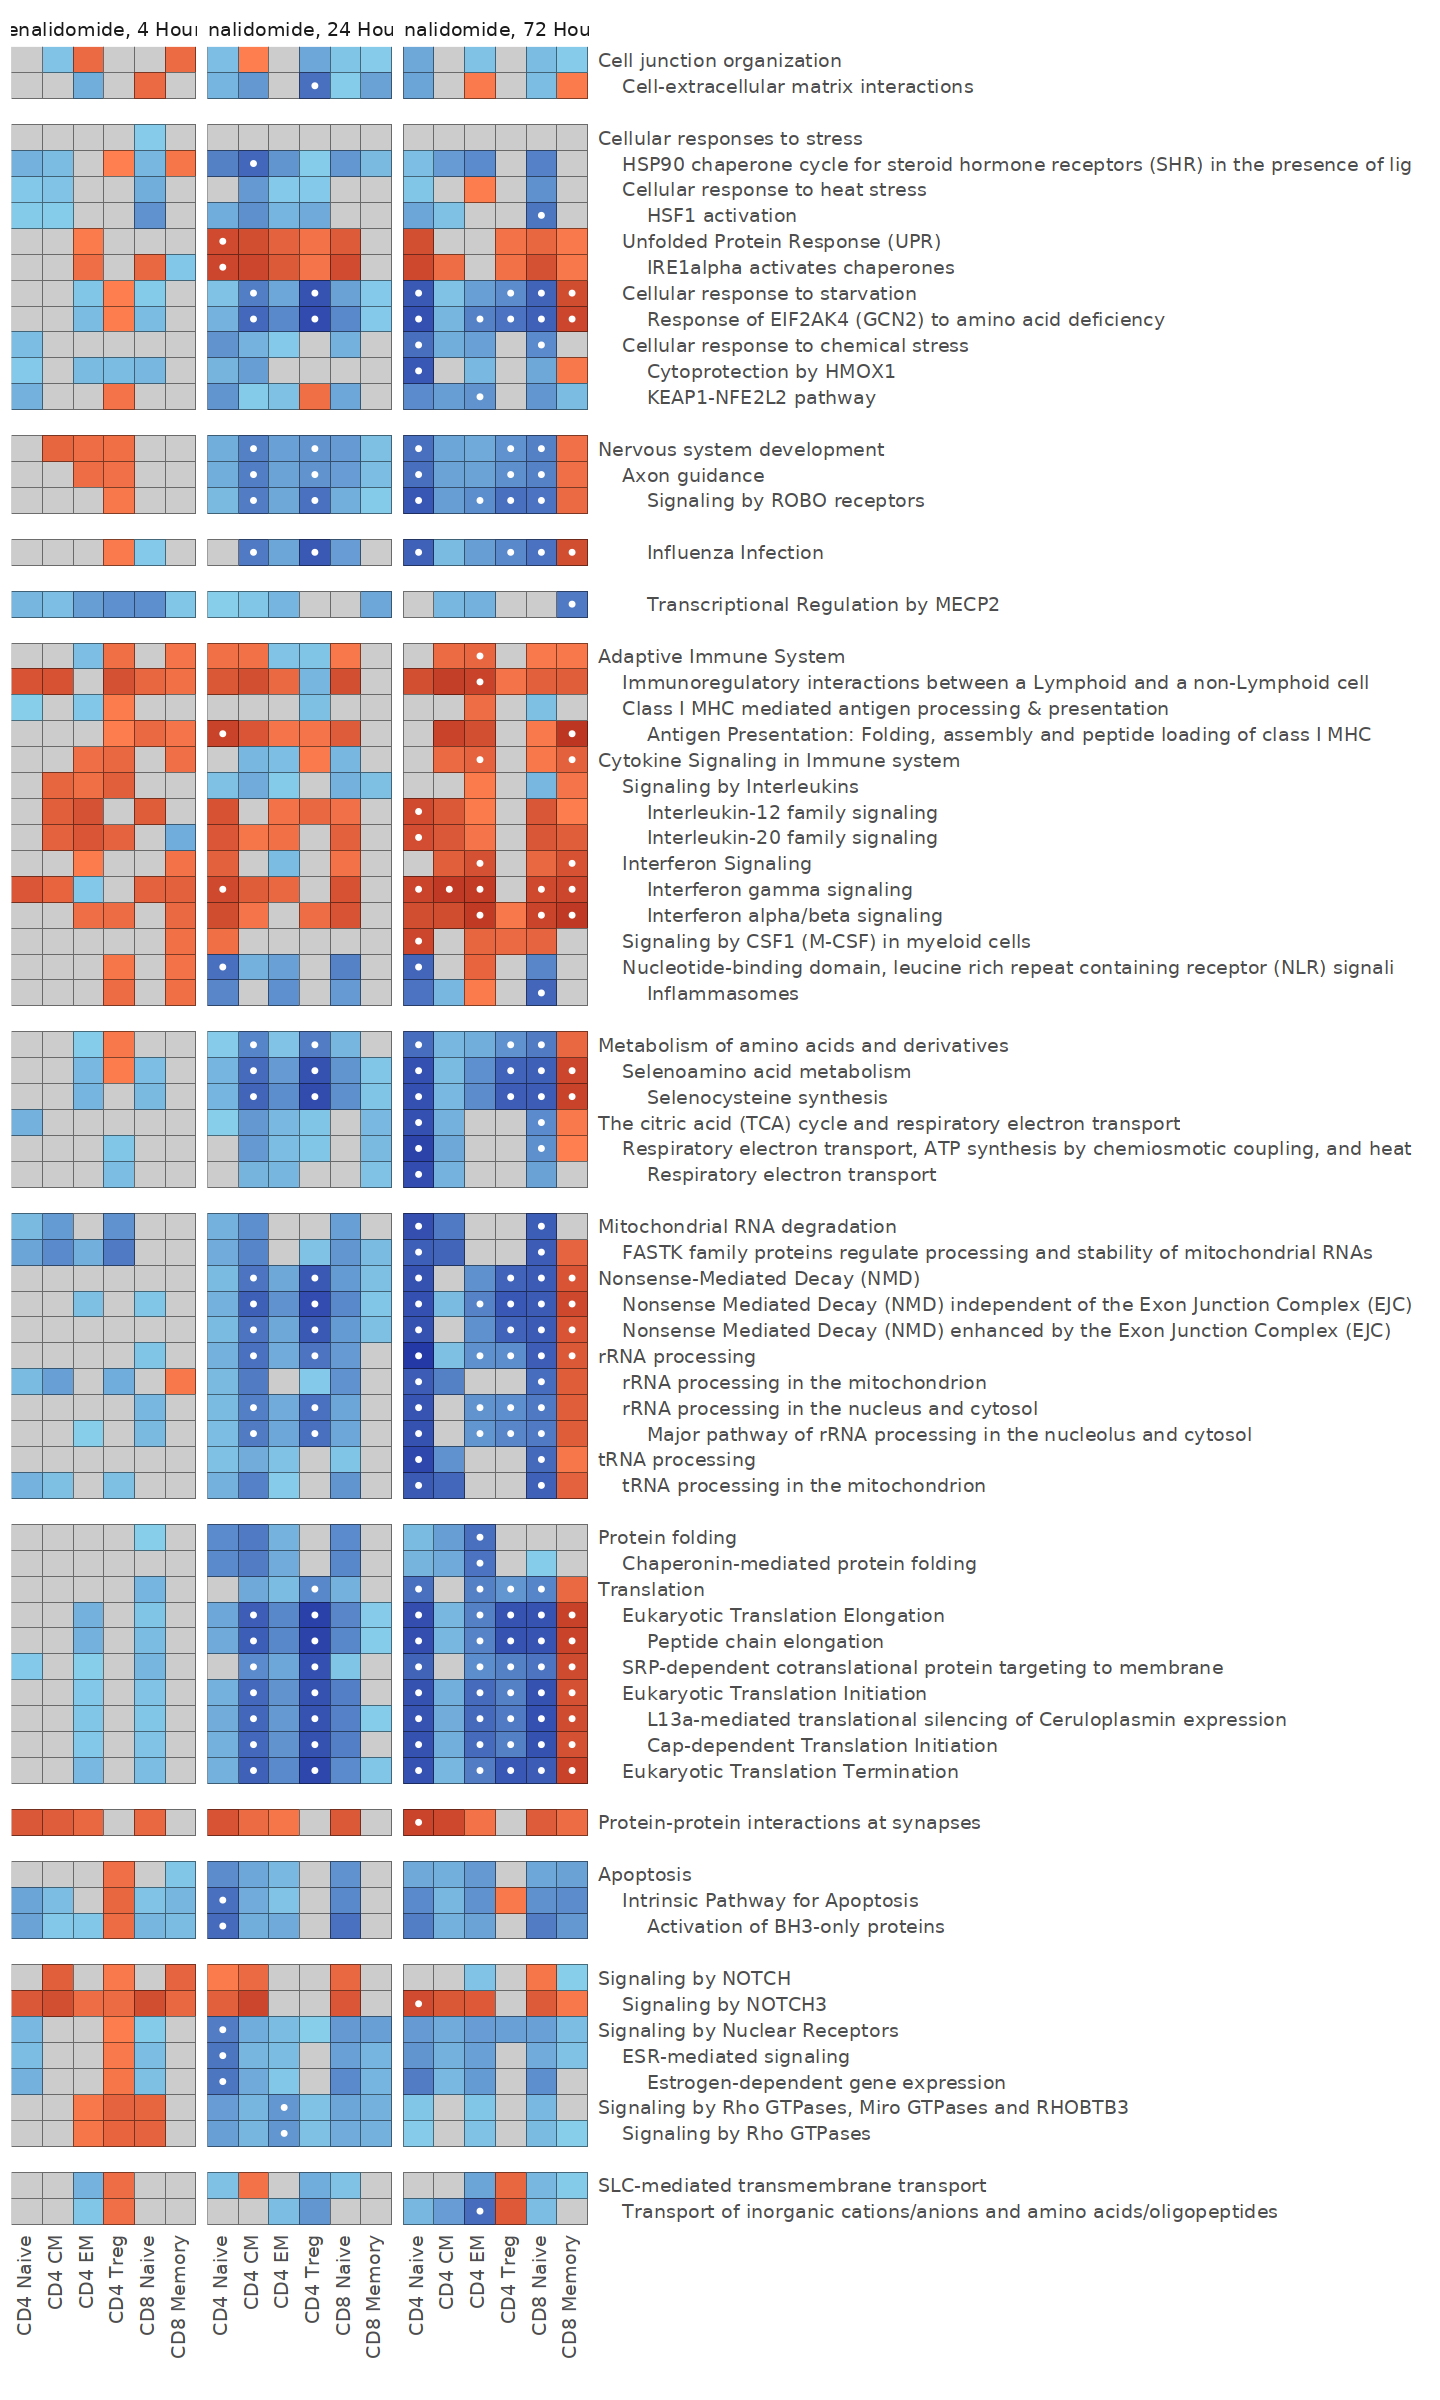

In [25]:
options(repr.plot.width = 12, repr.plot.height = 20)
reactome_heatmap <- ggplot() +
  geom_tile(
      data = missing_tiles,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black",
      fill = "gray80"
  ) +
  geom_tile(
      data = plot_data,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black") +
  geom_point(
      data = plot_data %>% filter(adjP < fdr_cutoff),
      aes(x = xpos,
          y = ypos),
      color = "white",
      size = 0.9) +
  scale_fill_identity() +
  scale_x_continuous(
      "",
      breaks = xpos_df$xpos,
      labels = xpos_df$cell_type_label,
      expand = c(0, 0)) +
  scale_y_continuous(
      "",
      breaks = ypos_df$ypos,
      labels = ypos_df$y_label,
      expand = c(0, 0),
      position = "right"
  ) +
  facet_wrap(~ timepoint_label) +
  theme_bw(base_size = 14) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.border = element_blank(),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())
reactome_heatmap

In [26]:
len_file <- file.path(
    out_dir,
    paste0("lenalidomide_reactome_heatmap_",Sys.Date(),".pdf")
)
ggsave(
    len_file,
    reactome_heatmap,
    width = 12, height = 20,
    limitsize = FALSE
)

## Plot Dexamethasone heatmap

In [27]:
fdr_cutoff <- 0.05

In [28]:
drug_data <- gsea_res %>%
  filter(fg == "dexamethasone") 

In [29]:
sig_data <- drug_data %>%
  filter(adjP < fdr_cutoff)

sig_pathways <- reactome_order %>%
  filter(name %in% sig_data$pathway)

In [30]:
parent_pathways <- map_dfr(
    1:nrow(sig_pathways),
    function(i) {
        row_l1 <- sig_pathways$l1_order[i]
        row_l2 <- sig_pathways$l2_order[i]
        row_l3 <- sig_pathways$l3_order[i]
        row_l4 <- sig_pathways$l4_order[i]
        
        if(row_l2 > 0) {
            l1_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == 0 & l3_order == 0)
        } else {
            l1_row <- reactome_order[0,]
        }
        
        if(row_l3 > 0) {
            l2_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == row_l2 & l3_order == 0)
        } else {
            l2_row <- reactome_order[0,]
        }
        
        if(row_l4 > 0) {
            l3_row <- reactome_order %>%
              filter(l1_order == row_l1 & l2_order == row_l2 & l3_order == row_l3)
        } else {
            l3_row <- reactome_order[0,]
        }
        rbind(l1_row, l2_row, l3_row)
    }
)
parent_pathways <- unique(parent_pathways)

In [31]:
plot_data <- drug_data %>%
  filter(pathway %in% sig_data$pathway | pathway_label %in% parent_pathways$pathway_label)

In [32]:
xpos_df <- plot_data %>%
  select(cell_type_label, cell_type_xpos) %>%
  unique() %>%
  arrange(cell_type_xpos) %>%
  mutate(xpos = 1:n())

ypos_df <- plot_data %>%
  select(pathway_label) %>%
  unique() %>%
  left_join(reactome_order) %>%
  arrange(set_order) %>%
  mutate(y_order = n():1) %>%
  mutate(y_label = case_when(
      grepl("^l1", pathway_label) ~ sub("l1_", "", pathway_label),
      grepl("^l2", pathway_label) ~ sub("l2_", "    ", pathway_label),
      grepl("^l3", pathway_label) ~ sub("l3_", "        ", pathway_label),
      grepl("^l4", pathway_label) ~ sub("l4_", "            ", pathway_label),
      TRUE ~ pathway_label
  ))

root_offset <- ypos_df %>%
  select(root_order) %>%
  unique() %>%
  mutate(y_offset = n():1)

ypos_df <- ypos_df %>%
  left_join(root_offset) %>%
  mutate(ypos = y_order + y_offset)

timepoint_df <- data.frame(
    timepoint = c(4, 24),
    timepoint_label = factor(c("Dexamethasone, 4 Hours", "Dexamethasone, 24 Hours"), 
                             levels = c("Dexamethasone, 4 Hours", "Dexamethasone, 24 Hours"))
)

Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(root_order)`


In [33]:
plot_data <- plot_data %>%
  left_join(xpos_df) %>%
  left_join(ypos_df) %>%
  mutate(NES = as.character(round(NES, 2))) %>%
  left_join(gc_df) %>%
  left_join(timepoint_df)

Joining with `by = join_by(cell_type_label, cell_type_xpos)`
Joining with `by = join_by(id, pathway_depth, pathway_label)`
Joining with `by = join_by(NES)`
Joining with `by = join_by(timepoint)`


In some cases, pathways are in two branches of the ontology. These won't get a y position assigned correctly, resulting in missing values. We can drop these to avoid warnings in the plotting process.

In [34]:
plot_data <- plot_data %>%
  filter(!is.na(ypos))

In [35]:
missing_tiles <- expand.grid(
    xpos = unique(plot_data$xpos),
    ypos = unique(plot_data$ypos),
    timepoint_label = unique(plot_data$timepoint_label)
)
missing_tiles <- missing_tiles %>%
  filter(
      !paste(xpos, ypos, timepoint_label) %in%
      paste(plot_data$xpos, plot_data$ypos, plot_data$timepoint_label)
  )

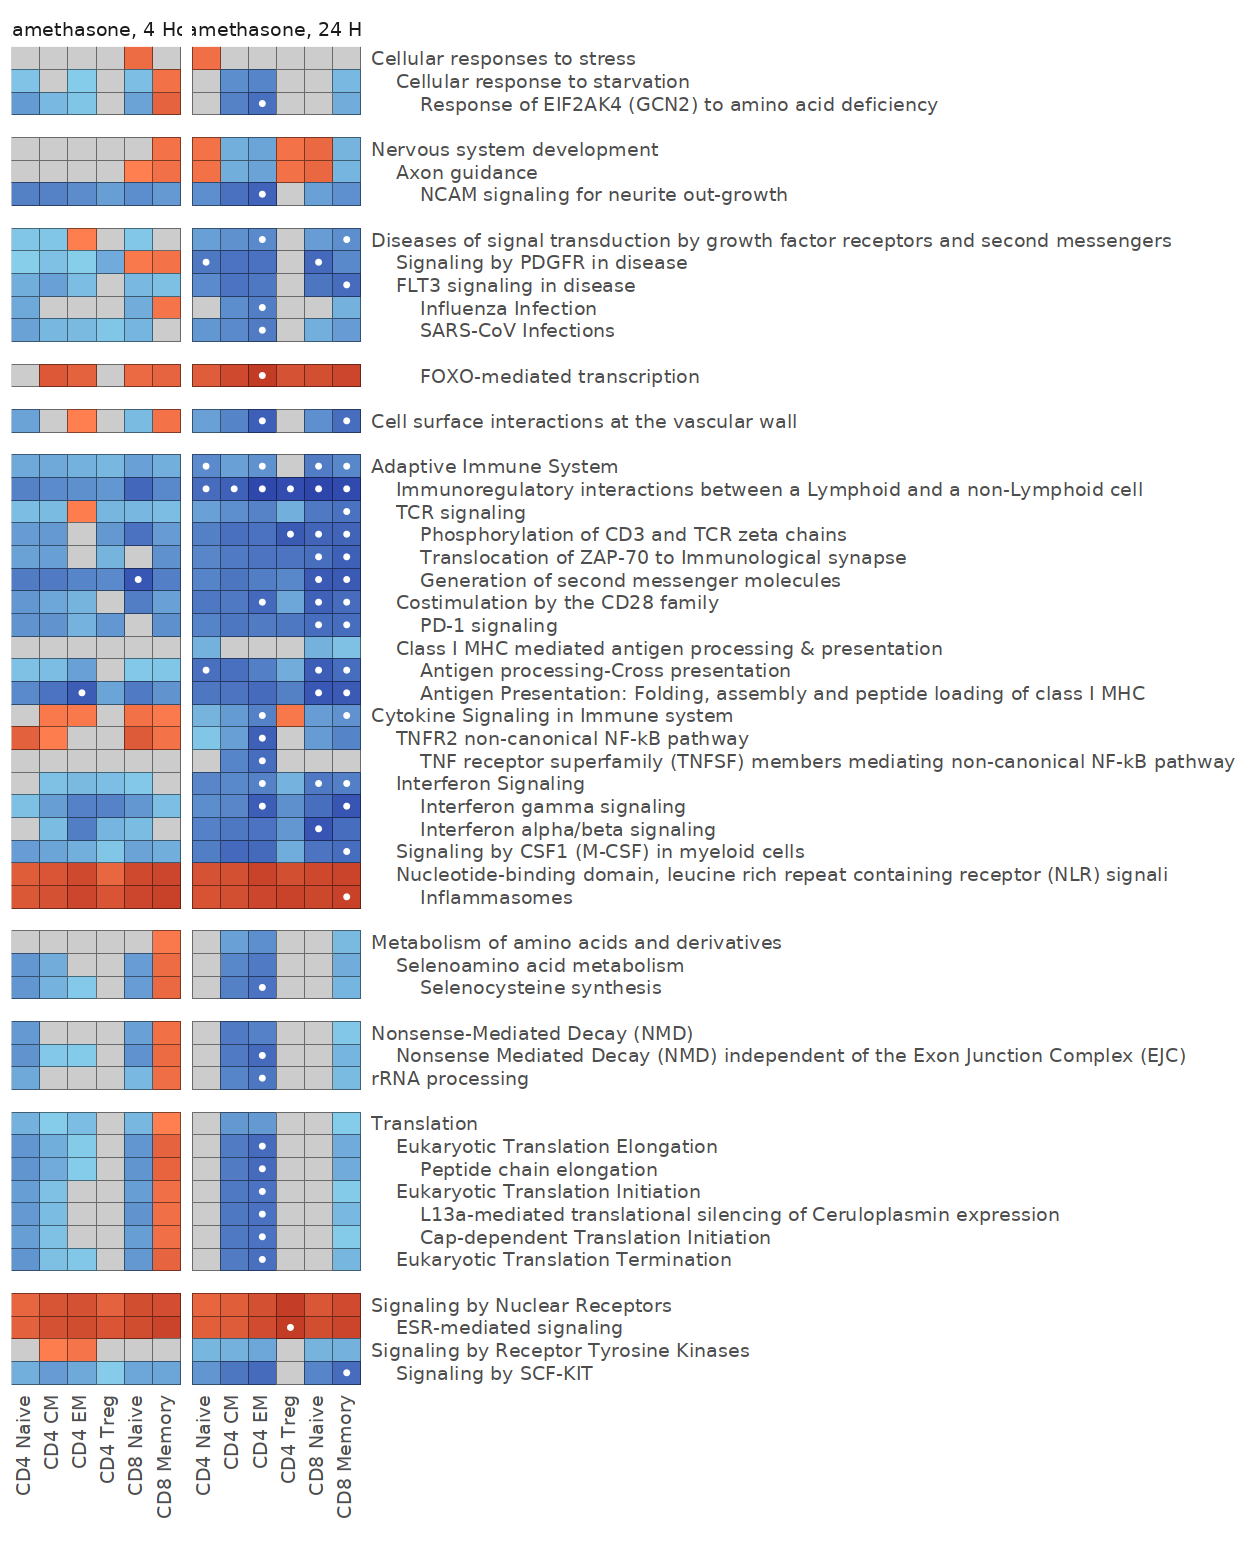

In [36]:
options(repr.plot.width = 10.5, repr.plot.height = 13)
reactome_heatmap <- ggplot() +
  geom_tile(
      data = missing_tiles,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black",
      fill = "gray80"
  ) +
  geom_tile(
      data = plot_data,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black") +
  geom_point(
      data = plot_data %>% filter(adjP < fdr_cutoff),
      aes(x = xpos,
          y = ypos),
      color = "white",
      size = 0.9) +
  scale_fill_identity() +
  scale_x_continuous(
      "",
      breaks = xpos_df$xpos,
      labels = xpos_df$cell_type_label,
      expand = c(0, 0)) +
  scale_y_continuous(
      "",
      breaks = ypos_df$ypos,
      labels = ypos_df$y_label,
      expand = c(0, 0),
      position = "right"
  ) +
  facet_wrap(~ timepoint_label) +
  theme_bw(base_size = 14) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.border = element_blank(),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank())
reactome_heatmap

In [37]:
dex_file <- file.path(
    out_dir,
    paste0("dexamethasone_reactome_heatmap_",Sys.Date(),".pdf")
)
ggsave(
    dex_file,
    reactome_heatmap,
    width = 10.5, height = 13,
    limitsize = FALSE
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [38]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Supp Fig 8", Sys.Date())

In [39]:
out_list <- as.list(c(len_file, dex_file))

In [40]:
out_list

[[1]]
[1] "output/supp_figure_08/lenalidomide_reactome_heatmap_2023-10-28.pdf"

[[2]]
[1] "output/supp_figure_08/dexamethasone_reactome_heatmap_2023-10-28.pdf"

In [41]:
in_list <- c(gsea_uuid, react_uuid)

In [42]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/repro-vrd-tea-seq/figures/Supp-Fig-08_len_dex_reactome.ipynb"
[1] "2) /home/jupyter/repro-vrd-tea-seq/figures/Supp-Fig-07_dde_heatmap.ipynb"
[1] "3) /home/jupyter/repro-vrd-tea-seq/figures/Supp-Fig-04_bortezomib_reactome.ipynb"


Please select (1-3)  1


$files
$files[[1]]
[1] "output/supp_figure_08/lenalidomide_reactome_heatmap_2023-10-28.pdf"

$files[[2]]
[1] "output/supp_figure_08/dexamethasone_reactome_heatmap_2023-10-28.pdf"


$traceId
[1] "4fafe29d-3a63-4afc-8a93-d38d536598cd"

In [43]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     bitops_1.0-7      assertthat_0.2.1 
 [9] textshaping_0.3.6 systemfonts_1.0.4 